# Import modules

In [1]:
from h5py import File
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import itertools

# Load file

In [2]:
filename = "/Users/kartik/Dropbox/ips6/Data/test/data.raw.h5"

# Explore the H5 file

In [15]:
f = File(filename, "r")
print(f"The following keys are in the H5 file: {f.keys()}")
print(f"You can explore the H5 files by typing f['notes']")
print(f['notes'])
print("f['notes'] does not have any members")
print(f['assay'])
print(f"/assay appears to have 3 members. We can further explore this by typing f['assay'].keys()")
print(f['assay'].keys())

The following keys are in the H5 file: <KeysViewHDF5 ['assay', 'bits', 'data_store', 'environment', 'hdf_version', 'mxw_version', 'notes', 'recordings', 'version', 'wellplate', 'wells']>
You can explore the H5 files by typing f['notes']
<HDF5 group "/notes" (0 members)>
f['notes'] does not have any members
<HDF5 group "/assay" (3 members)>
/assay appears to have 3 members. We can further explore this by typing f['assay'].keys()
<KeysViewHDF5 ['inputs', 'run_id', 'script_id']>


In hindsight, using f as a variable name as well as F-strings is a bit confusing. Hopefully the above made sense. Basically we can explore the H5 file. The important stuff for raster/spiking data is stored in "data_store". If I remember correctly, it might also be in wells.

In [3]:
def extract_spikes_from_h5(filename):
    try:
        f = File(filename, "r")
        recordings = f["data_store"]["data0000"]
        spikes = np.array(recordings["spikes"])

        channel = spikes["channel"]
        time = (spikes["frameno"] - (min(spikes["frameno"]))) / 20000  # If I remember correctly, frameno does not start at 0 but rather datetime of when the recording took place
        duration = recordings["stop_time"][0] - recordings["start_time"][0] # This doesn't get used

        # This part just organizes the spiking times based on the channel they belong to.
        # Produces a list of list, where each list contains all the spikes times belonging to a specific channel.
        channel_times = {}
        for c, t in zip(channel, time):
            if c not in channel_times:
                channel_times[c] = []
            channel_times[c].append(t)
        raster = [channel_times[channel] for channel in sorted(channel_times)]
        return channel, time, raster

    except:
        print("Path does not contain an h5 file")
        return [], [], []

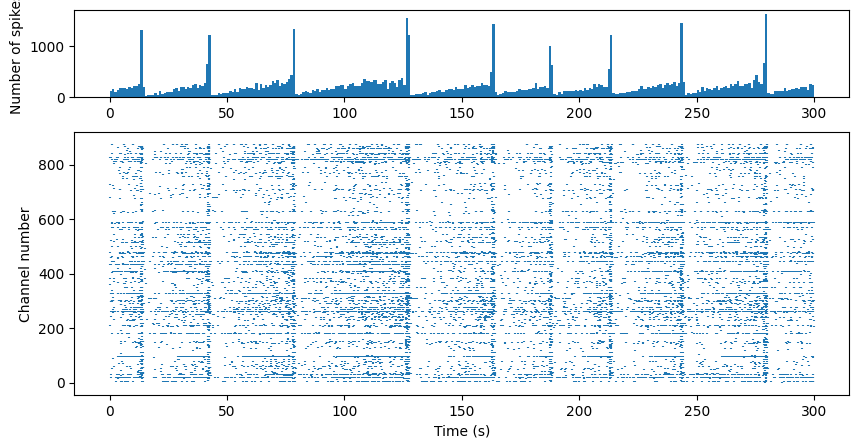

In [5]:
# Get raster plot stored as a list of list, where each list is the spike times from a channel
channel, time, raster = extract_spikes_from_h5(filename)
# Concatenate list of list of spike times (i.e. raster) to make a firing rate histogram
all_spiketimes = list(itertools.chain.from_iterable(raster))


fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])

ax0.hist(all_spiketimes, 300)
ax0.set_ylabel("Number of spikes")

ax1.eventplot(raster)
ax1.set_ylabel("Channel number")
ax1.set_xlabel("Time (s)")

plt.show()